MVP: PIPELINE DE DADOS

AUTOR: LEANDRO JORDAO DE OLIVEIRA BARROS

DATA: 16/12/2025

MATRÍCULA: 4052025000893

DATASET: Credit card Details Binary Classification Problem (Kaggle - https://www.kaggle.com/datasets/rohitudageri/credit-card-details)




I) Problema:

Trabalho na Caixa Econômica e a ideia é criar um PIPELINE prático para utilizar no dia a dia do nosso atedimento para uma das solicitações mais comuns do atendimento de varejo: Aprovar ou não um cartão de crédito para um cliente.

Quais os dados são mais importantes para essa análise?


II) Escolhemos o DATASET: Credit card Details Binary Classification Problem (Kaggle) para trabalhar, fazer o histórico de dados e criar o nosso critério de análise.



III) Importação da base de dados e tratamento das variáveis 

In [0]:
import pandas as pd
import sqlite3
import numpy as np

# 1) Carregar CSV do GitHub
url = "https://github.com/LeandroJordao1979/MVPBancodeDadosPipeline/raw/main/pipeline_credit_final.csv"
df = pd.read_csv(url)

# 2) Renomear colunas para português
df = df.rename(columns={
    'Ind_ID': 'id_cliente',
    'Birthday_count': 'birthday_count',
    'Marital_status': 'estado_civil',
    'CHILDREN': 'numero_filhos',
    'Employed_days': 'dias_empregado',
    'Annual_income': 'renda_anual'
})

# 3) Converter idade em anos
df['idade'] = (df['birthday_count'].fillna(0) / 365).abs().astype(int)

# 4) Normalizar estado civil
def normaliza_estado_civil(s):
    if pd.isna(s): return 'Outros'
    s = str(s).lower()
    if 'married' in s: return 'Casado'
    if 'single' in s: return 'Solteiro'
    return 'Outros'

df['estado_civil'] = df['estado_civil'].apply(normaliza_estado_civil)

# 5) Limpezas complementares
df['dias_empregado'] = df['dias_empregado'].fillna(0).abs().astype(int)
df['numero_filhos'] = df['numero_filhos'].fillna(0).astype(int)
df['renda_anual'] = pd.to_numeric(df['renda_anual'], errors='coerce')

# 6) Selecionar colunas finais da DIM_CLIENTE
dim_cliente_df = df[['id_cliente','idade','estado_civil','numero_filhos','dias_empregado','renda_anual']].drop_duplicates(subset=['id_cliente'])

# 7) Converter tipos explicitamente
dim_cliente_df['id_cliente'] = dim_cliente_df['id_cliente'].astype(int)
dim_cliente_df['idade'] = dim_cliente_df['idade'].astype(int)
dim_cliente_df['numero_filhos'] = dim_cliente_df['numero_filhos'].astype(int)
dim_cliente_df['dias_empregado'] = dim_cliente_df['dias_empregado'].astype(int)
dim_cliente_df['renda_anual'] = dim_cliente_df['renda_anual'].astype(float)

# 8) Criar banco SQLite
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE DIM_CLIENTE (
    id_cliente INTEGER PRIMARY KEY,
    idade INTEGER,
    estado_civil TEXT,
    numero_filhos INTEGER,
    dias_empregado INTEGER,
    renda_anual REAL
);
""")

# 9) Inserir dados
records = []
for row in dim_cliente_df.itertuples(index=False):
    records.append((
        int(row.id_cliente),
        int(row.idade),
        str(row.estado_civil),
        int(row.numero_filhos),
        int(row.dias_empregado),
        float(row.renda_anual) if not pd.isna(row.renda_anual) else None
    ))

cursor.executemany("""
INSERT INTO DIM_CLIENTE (id_cliente, idade, estado_civil, numero_filhos, dias_empregado, renda_anual)
VALUES (?, ?, ?, ?, ?, ?)
""", records)
conn.commit()

print("DIM_CLIENTE carregada com sucesso!")

# 10) Conferir os primeiros registros
dim_cliente_df.head()

DIM_CLIENTE carregada com sucesso!


,id_cliente,idade,estado_civil,numero_filhos,dias_empregado,renda_anual
0,5008827,51,Casado,0,0,180000.0
1,5009744,37,Casado,0,586,315000.0
2,5009746,0,Casado,0,586,315000.0
3,5009749,37,Casado,0,586,NaN
4,5009752,37,Casado,0,586,315000.0


DIAGRAMA DE MER


## 📊 Diagramas do Projeto

### 🔹 Diagrama MER
![Diagrama MER](https://github.com/LeandroJordao1979/MVPBancodeDadosPipeline/blob/main/MER%20trabalho%20MVP%20Banco%20de%20Dados.png?raw=true)




[CLIENTE] ----------------< SOLICITA >---------------- [CREDITO] ----------------< AVALIADO_POR >---------------- [CRITERIO]




CLIENTE 1:N CREDITO (um cliente pode solicitar vários créditos).

CREDITO N:M CRITERIO (um crédito é avaliado por vários critérios).


DIAGRAMA ESTRELA

### 🔹 Diagrama Estrela
![Diagrama Estrela](https://github.com/LeandroJordao1979/MVPBancodeDadosPipeline/blob/main/Diagrama%20ESTRELA.png?raw=true)

CRIANDO AS TABELAS

DIM CRITERIO

In [0]:
# Criar DIM_CRITERIO
cursor.execute("""
CREATE TABLE DIM_CRITERIO (
    id_criterio INTEGER PRIMARY KEY,
    descricao TEXT,
    tipo TEXT,
    valor_limite REAL
);
""")
conn.commit()
print("DIM_CRITERIO criada.")

DIM_CRITERIO criada.


DIM TEMPO

In [0]:
# Criar DIM_TEMPO
cursor.execute("""
CREATE TABLE DIM_TEMPO (
    id_tempo INTEGER PRIMARY KEY,
    data_solicitacao DATE,
    ano INTEGER,
    mes INTEGER,
    dia INTEGER
);
""")
conn.commit()
print("DIM_TEMPO criada com sucesso!")

DIM_TEMPO criada com sucesso!


CARREGANDO DIM TEMPO COM VALORES FICTICIOS

In [0]:
cursor.executemany("""
INSERT INTO DIM_TEMPO (id_tempo, data_solicitacao, ano, mes, dia)
VALUES (?, ?, ?, ?, ?)
""", [
    (1, '2025-12-21', 2025, 12, 21),
    (2, '2025-12-20', 2025, 12, 20),
    (3, '2025-11-15', 2025, 11, 15)
])
conn.commit()

print("DIM_TEMPO populada com sucesso!")

DIM_TEMPO populada com sucesso!


In [0]:
pd.read_sql_query("SELECT * FROM DIM_TEMPO;", conn)

,id_tempo,data_solicitacao,ano,mes,dia
0,1,2025-12-21,2025,12,21
1,2,2025-12-20,2025,12,20
2,3,2025-11-15,2025,11,15


FATO CREDITO

In [0]:
# Criar FATO_CREDITO
cursor.execute("""
CREATE TABLE FATO_CREDITO (
    id_credito INTEGER PRIMARY KEY,
    id_cliente INTEGER,
    id_criterio INTEGER,
    id_tempo INTEGER,
    valor REAL,
    status TEXT,
    FOREIGN KEY (id_cliente) REFERENCES DIM_CLIENTE(id_cliente),
    FOREIGN KEY (id_criterio) REFERENCES DIM_CRITERIO(id_criterio),
    FOREIGN KEY (id_tempo) REFERENCES DIM_TEMPO(id_tempo)
);
""")
conn.commit()
print("FATO_CREDITO criada com sucesso!")

FATO_CREDITO criada com sucesso!


In [0]:
cursor.executemany("""
INSERT INTO FATO_CREDITO (id_credito, id_cliente, id_criterio, id_tempo, valor, status)
VALUES (?, ?, ?, ?, ?, ?)
""", [
    (1001, 1, 1, 1, 20000, None),
    (1002, 2, 1, 2, 15000, None),
    (1003, 3, 2, 3, 50000, None)
])
conn.commit()

print("Solicitações de crédito inseridas na FATO_CREDITO.")

Solicitações de crédito inseridas na FATO_CREDITO.


AVALIAÇÃO 

In [0]:
cursor.execute("DROP VIEW IF EXISTS V_AVALIACAO;")
cursor.execute("""
CREATE VIEW V_AVALIACAO AS
SELECT
    f.id_credito,
    c.id_cliente,
    c.idade,
    c.estado_civil,
    c.numero_filhos,
    c.dias_empregado,
    c.renda_anual,
    CASE
        WHEN c.idade < (SELECT valor_limite FROM DIM_CRITERIO WHERE tipo='idade') THEN 'reprovado'
        WHEN c.estado_civil NOT IN ('Casado','Solteiro','Solteira') THEN 'reprovado'
        WHEN c.numero_filhos > (SELECT valor_limite FROM DIM_CRITERIO WHERE tipo='filhos') THEN 'reprovado'
        WHEN c.dias_empregado < (SELECT valor_limite FROM DIM_CRITERIO WHERE tipo='dias empregado') THEN 'reprovado'
        WHEN c.renda_anual < (SELECT valor_limite FROM DIM_CRITERIO WHERE tipo='renda anual') THEN 'reprovado'
        ELSE 'aprovado'
    END AS status_calculado
FROM FATO_CREDITO f
JOIN DIM_CLIENTE c ON f.id_cliente = c.id_cliente;
""")
conn.commit()

print("View V_AVALIACAO criada com sucesso!")

View V_AVALIACAO criada com sucesso!


ATUALIZAÇÃO FATO CREDITO

In [0]:
cursor.execute("""
UPDATE FATO_CREDITO
SET status = (
    SELECT v.status_calculado
    FROM V_AVALIACAO v
    WHERE v.id_credito = FATO_CREDITO.id_credito
);
""")
conn.commit()

print("Status atualizado na FATO_CREDITO.")

Status atualizado na FATO_CREDITO.


In [0]:
pd.read_sql_query("SELECT * FROM FATO_CREDITO;", conn)

,id_credito,id_cliente,id_criterio,id_tempo,valor,status
0,1001,1,1,1,20000.0,None
1,1002,2,1,2,15000.0,None
2,1003,3,2,3,50000.0,None


APROVADOS E REPROVADOS NA ANÁLISE COM SEUS MOTIVOS DE REPROVAÇÃO

In [0]:
import pandas as pd

# 1) Quantidade de aprovados e reprovados
aprov_reprov = pd.read_sql_query("""
SELECT status, COUNT(*) AS total
FROM FATO_CREDITO
GROUP BY status;
""", conn)

print("Resumo de Aprovação/Reprovação:")
print(aprov_reprov)

# 2) Motivos das reprovações
motivos = pd.read_sql_query("""
SELECT f.id_credito, f.id_cliente,
       CASE
           WHEN c.idade < (SELECT valor_limite FROM DIM_CRITERIO WHERE tipo='idade') THEN 'Idade insuficiente'
           WHEN c.estado_civil NOT IN ('Casado','Solteiro','Solteira') THEN 'Estado civil não aceito'
           WHEN c.numero_filhos > (SELECT valor_limite FROM DIM_CRITERIO WHERE tipo='filhos') THEN 'Número de filhos acima do limite'
           WHEN c.dias_empregado < (SELECT valor_limite FROM DIM_CRITERIO WHERE tipo='dias empregado') THEN 'Pouco tempo empregado'
           WHEN c.renda_anual < (SELECT valor_limite FROM DIM_CRITERIO WHERE tipo='renda anual') THEN 'Renda insuficiente'
           ELSE 'Outros'
       END AS motivo
FROM FATO_CREDITO f
JOIN DIM_CLIENTE c ON f.id_cliente = c.id_cliente
WHERE f.status = 'reprovado';
""", conn)

print("\nMotivos das reprovações:")
print(motivos)

Resumo de Aprovação/Reprovação:
  status  total
0   None      3

Motivos das reprovações:
Empty DataFrame
Columns: [id_credito, id_cliente, motivo]
Index: []


AVALIAÇÃO EM CIMA DO DATASET

CRITÉRIOS DE ANÁLISE

   id_cliente  idade estado_civil  ...  dias_empregado  renda_anual     status
0     5008827     51       Casado  ...               0     180000.0  reprovado
1     5009744     37       Casado  ...             586     315000.0   aprovado
2     5009746      0       Casado  ...             586     315000.0  reprovado
3     5009749     37       Casado  ...             586          NaN   aprovado
4     5009752     37       Casado  ...             586     315000.0   aprovado

[5 rows x 7 columns]

Resumo de Aprovação/Reprovação:
      status  total
0   aprovado    979
1  reprovado    569


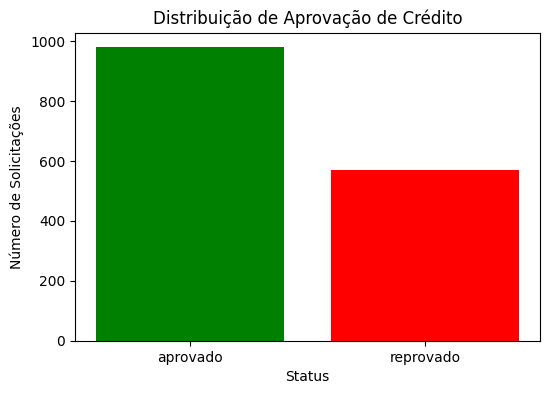

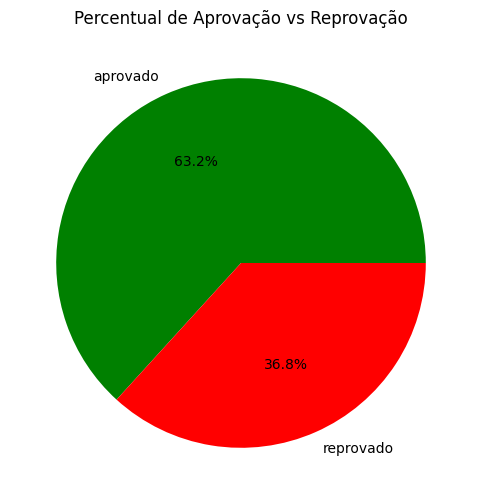

In [0]:
import matplotlib.pyplot as plt

# Função de avaliação
def avaliar_cliente(row):
    if row['idade'] < 18:
        return 'reprovado'
    if row['estado_civil'] not in ['Casado','Solteiro','Solteira']:
        return 'reprovado'
    if row['numero_filhos'] > 3:
        return 'reprovado'
    if row['dias_empregado'] < 365:
        return 'reprovado'
    if row['renda_anual'] < 60000:
        return 'reprovado'
    return 'aprovado'

# Aplicar avaliação
df['status'] = df.apply(avaliar_cliente, axis=1)

# Mostrar primeiros registros avaliados
print(df[['id_cliente','idade','estado_civil','numero_filhos','dias_empregado','renda_anual','status']].head())

# -------------------------------
# Relatório de aprovados e reprovados
# -------------------------------
aprov_reprov = df['status'].value_counts().reset_index()
aprov_reprov.columns = ['status','total']

print("\nResumo de Aprovação/Reprovação:")
print(aprov_reprov)

# -------------------------------
# Gráfico de barras
# -------------------------------
plt.figure(figsize=(6,4))
plt.bar(aprov_reprov['status'], aprov_reprov['total'], color=['green','red'])
plt.title("Distribuição de Aprovação de Crédito")
plt.xlabel("Status")
plt.ylabel("Número de Solicitações")
plt.show()

# -------------------------------
# Gráfico de pizza
# -------------------------------
plt.figure(figsize=(6,6))
plt.pie(aprov_reprov['total'], labels=aprov_reprov['status'], autopct='%1.1f%%', colors=['green','red'])
plt.title("Percentual de Aprovação vs Reprovação")
plt.show()

AVALIAÇÃO DA BASE E DE POSSIVEIS CLIENTES A PARTIR DA INSERÇÃO DE DADOS NAS CÉLULAS DE WIDGETS COM A SAÍDA DO RESULTADO APÓS "RODAR" A CÉLULA

Resumo de Aprovação/Reprovação:
      status  total
0   aprovado    986
1  reprovado    562


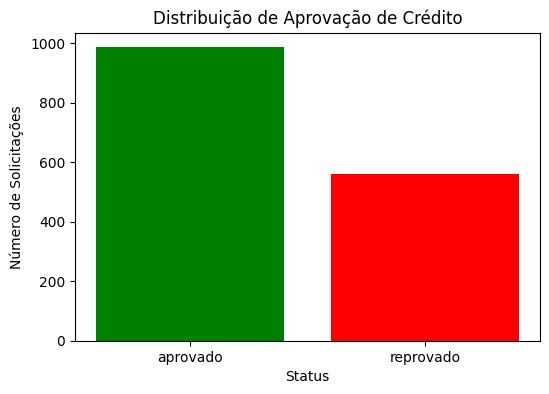

Resultado da análise do cliente digitado: reprovado


In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Função de avaliação (critérios)
# -------------------------------
def avaliar_cliente(row):
    if row['idade'] < 21:
        return 'reprovado'
    if row['estado_civil'] not in ['Casado','Solteiro','Solteira']:
        return 'reprovado'
    if row['numero_filhos'] > 3:
        return 'reprovado'
    if row['dias_empregado'] < 365:
        return 'reprovado'
    if row['renda_anual'] < 30000:
        return 'reprovado'
    return 'aprovado'

# -------------------------------
# 1) Avaliação da base inteira
# -------------------------------
df['status'] = df.apply(avaliar_cliente, axis=1)

# Relatório geral
aprov_reprov = df['status'].value_counts().reset_index()
aprov_reprov.columns = ['status','total']

print("Resumo de Aprovação/Reprovação:")
print(aprov_reprov)

# Gráfico de barras
plt.figure(figsize=(6,4))
plt.bar(aprov_reprov['status'], aprov_reprov['total'], color=['green','red'])
plt.title("Distribuição de Aprovação de Crédito")
plt.xlabel("Status")
plt.ylabel("Número de Solicitações")
plt.show()

# -------------------------------
# 2) Avaliação de cliente individual (Databricks Widgets)
# -------------------------------
# Criar widgets para entrada manual
dbutils.widgets.text("idade", "30", "Idade")
dbutils.widgets.text("estado_civil", "Solteiro", "Estado Civil")
dbutils.widgets.text("numero_filhos", "2", "Número de Filhos")
dbutils.widgets.text("dias_empregado", "400", "Dias Empregado")
dbutils.widgets.text("renda_anual", "35000", "Renda Anual")

# Ler valores digitados
idade = int(dbutils.widgets.get("idade"))
estado_civil = dbutils.widgets.get("estado_civil")
numero_filhos = int(dbutils.widgets.get("numero_filhos"))
dias_empregado = int(dbutils.widgets.get("dias_empregado"))
renda_anual = float(dbutils.widgets.get("renda_anual"))

# Avaliar cliente individual
def avaliar_cliente_dict(idade, estado_civil, numero_filhos, dias_empregado, renda_anual):
    if idade < 21:
        return 'reprovado'
    if estado_civil not in ['Casado','Solteiro','Solteira']:
        return 'reprovado'
    if numero_filhos > 3:
        return 'reprovado'
    if dias_empregado < 365:
        return 'reprovado'
    if renda_anual < 30000:
        return 'reprovado'
    return 'aprovado'

resultado = avaliar_cliente_dict(idade, estado_civil, numero_filhos, dias_empregado, renda_anual)
print(f"Resultado da análise do cliente digitado: {resultado}")

In [0]:
# Criar widgets para entrada manual
dbutils.widgets.text("idade", "30", "Idade")
dbutils.widgets.text("estado_civil", "Solteiro", "Estado Civil")
dbutils.widgets.text("numero_filhos", "2", "Número de Filhos")
dbutils.widgets.text("dias_empregado", "400", "Dias Empregado")
dbutils.widgets.text("renda_anual", "35000", "Renda Anual")

In [0]:
# Ler valores dos widgets
idade = int(dbutils.widgets.get("idade"))
estado_civil = dbutils.widgets.get("estado_civil")
numero_filhos = int(dbutils.widgets.get("numero_filhos"))
dias_empregado = int(dbutils.widgets.get("dias_empregado"))
renda_anual = float(dbutils.widgets.get("renda_anual"))

# Função de avaliação
def avaliar_cliente_dict(idade, estado_civil, numero_filhos, dias_empregado, renda_anual):
    if idade < 21:
        return 'reprovado'
    if estado_civil not in ['Casado','Solteiro','Solteira']:
        return 'reprovado'
    if numero_filhos > 3:
        return 'reprovado'
    if dias_empregado < 365:
        return 'reprovado'
    if renda_anual < 30000:
        return 'reprovado'
    return 'aprovado'

# Mostrar resultado diretamente no output
resultado = avaliar_cliente_dict(idade, estado_civil, numero_filhos, dias_empregado, renda_anual)
print(f"Resultado da análise do cliente digitado: {resultado}")

Resultado da análise do cliente digitado: reprovado


CONCLUSÃO: 

Após análise do dataset que realizamos no Colab consideramos as variáveis Dias Empregado, Estado Civil, Idade, Número de Filhos e Renda Anual como importantes para nosso critério de análise de crédito. A partir disto criamos nossas tabelas de relacionamento conforme diagramas de MER e ESTRELA aresentados e o input de dados nos widgets que nos permitem uma resposta rápida com poucos dados obtidos do cliente (Os critérios precisarão ser analisados posteriormente e adaptados sempre em função dos critérios do sistema Caixa, mas para uma pré análise pode ser uma ótima ferramenta de utilização diária).

Com relação a nossa base de dados, podemos dizer que se trata de uma base pobre em relação a utilização como base para criação de critérios de análise. No entando, a planilha esta praticamente toda preenchida, o que favorece muito, pois precisamos mexer pouco na base de dados. Fizemos mudanças apenas para facilitar nossa análise e criar o código para obter uma ferramenta útil. Desta forma, atendemos a nossa proposta incial e respondemos postivamente a nossa ideia inicial do projeto.

Segue link com as análises do dataset no colab

https://colab.research.google.com/drive/1FH8rrqgT1_hAwDeAcInWAvMP7dTpOuE_#scrollTo=H8ulV-z2hrA-